# 0. Imports

In [59]:
import warnings
warnings.filterwarnings('ignore')

import re
import sweetviz                   as sv
import numpy                      as np
import pandas                     as pd
import seaborn                    as sns

import matplotlib.pyplot          as plt
from plotly import express        as px
import scipy.stats                as stats
from sklearn import preprocessing as pp
from sklearn import decomposition as dd
from sklearn import manifold      as mn
from sklearn import ensemble      as en
from sklearn import cluster       as c
from sklearn import mixture       as mx
import dtale
import umap.umap_ as umap


## 0.2 Load Dataset

In [60]:
df_raw = pd.read_csv('data.csv', encoding='ISO-8859-1')
df_raw = df_raw.drop(columns=['Unnamed: 8'], axis=1)

# 1. Data Description

In [61]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [62]:
cols = ['invoice_no', 'stock_code', 'description', 'quantity', 'invoice_date', 'unit_price', 'customer_id', 'country']
df1.columns = cols

## 1.2 Data Dimensions

In [63]:
df1.shape

(541909, 8)

## 1.3 Data Types

In [64]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
customer_id     float64
country          object
dtype: object

## 1.4 Check N/A

In [65]:
df1.isna().sum()

invoice_no           0
stock_code           0
description       1454
quantity             0
invoice_date         0
unit_price           0
customer_id     135080
country              0
dtype: int64

## 1.5 Replace N/A

In [66]:
# customer id
df_missing = df1.loc[df1['customer_id'].isna(), :]

# create reference
df_ref_missing = pd.DataFrame( df1['invoice_no'].drop_duplicates() )
df_ref_missing['customer_id'] = np.arange(19000, 19000+len(df_ref_missing), 1)

# merge
df1 = pd.merge(df1, df_ref_missing, on='invoice_no', how='left')

# coalesce 
df1['customer_id'] = df1['customer_id_x'].combine_first(df1['customer_id_y'])

# drop extra columns
df1 = df1.drop(columns=['customer_id_x', 'customer_id_y'], axis=1)

df1.head()

,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,29-Nov-16,2.55,United Kingdom,17850.0
1,536365,71053,WHITE METAL LANTERN,6,29-Nov-16,3.39,United Kingdom,17850.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,29-Nov-16,2.75,United Kingdom,17850.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,29-Nov-16,3.39,United Kingdom,17850.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,29-Nov-16,3.39,United Kingdom,17850.0


In [67]:
df1.isna().sum()

invoice_no         0
stock_code         0
description     1454
quantity           0
invoice_date       0
unit_price         0
country            0
customer_id        0
dtype: int64

## 1.6 Change Dtypes

In [68]:
df1.dtypes

invoice_no       object
stock_code       object
description      object
quantity          int64
invoice_date     object
unit_price      float64
country          object
customer_id     float64
dtype: object

In [69]:
# invoice date
df1['invoice_date'] = pd.to_datetime(df1['invoice_date'], format='%d-%b-%y')

# customer id
df1.customer_id = df1.customer_id.astype('int64')

In [70]:
df1.dtypes

invoice_no              object
stock_code              object
description             object
quantity                 int64
invoice_date    datetime64[ns]
unit_price             float64
country                 object
customer_id              int64
dtype: object

## 1.7 Descriptive Statistics

In [71]:
num_attributes = df1.select_dtypes(include=['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])


### 1.7.1 Numerical Attributes

In [72]:
# mean, meadian, std, min, max

ct1 = pd.DataFrame(num_attributes.apply(lambda x: x.mean())).T
ct2 = pd.DataFrame(num_attributes.apply(lambda x: x.median())).T
ct3 = pd.DataFrame(num_attributes.apply(lambda x: x.std())).T
ct4 = pd.DataFrame(num_attributes.apply(lambda x: x.min())).T
ct5 = pd.DataFrame(num_attributes.apply(lambda x: x.max())).T

ct_aux = pd.concat([ct1, ct2, ct3, ct4, ct5]).T.reset_index()
ct_aux.columns = ['attributes', 'mean', 'median', 'std', 'min', 'max']

ct_aux

,attributes,mean,median,std,min,max
0,quantity,9.552250,3.00,218.081158,-80995.00,80995.0
1,unit_price,4.611114,2.08,96.759853,-11062.06,38970.0
2,customer_id,19302.852687,16249.00,8205.600788,12346.00,44874.0


### 1.7.2 Categorical Attributes

In [73]:
letter_invoices = df1.loc[df1['invoice_no'].apply( lambda x: bool( re.search( '[^0-9]+', x))), :]
letter_invoices


,invoice_no,stock_code,description,quantity,invoice_date,unit_price,country,customer_id
141,C536379,D,Discount,-1,2016-11-29,27.50,United Kingdom,14527
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2016-11-29,4.65,United Kingdom,15311
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2016-11-29,1.65,United Kingdom,17548
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2016-11-29,0.29,United Kingdom,17548
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2017-12-07,0.83,United Kingdom,14397
541541,C581499,M,Manual,-1,2017-12-07,224.69,United Kingdom,15498
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2017-12-07,10.95,United Kingdom,15311
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2017-12-07,1.25,United Kingdom,17315


In [74]:
# Stock codes with only letters
df1.loc[df1['stock_code'].apply(lambda x: bool(re.search('^[a-zA-Z]+$', x))), 'stock_code'].unique()

array(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'], dtype=object)

In [75]:
df1['country'].value_counts(normalize=True).head()

country
United Kingdom    0.914320
Germany           0.017521
France            0.015790
EIRE              0.015124
Spain             0.004674
Name: proportion, dtype: float64

# 2. Variables Filtering 

In [76]:
df2 = df1.copy()

In [77]:
# stock code
df2 = df2[~df2['stock_code'].isin(['POST', 'D', 'DOT', 'M', 'S', 'AMAZONFEE', 'm', 'DCGSSBOY',
       'DCGSSGIRL', 'PADS', 'B', 'CRUK'])]

# unit price
df2 = df2.loc[df2['unit_price'] >= 0.04, :]

# description
df2 = df2.drop(columns=['description'], axis=1)

# country
df2 = df2[~df2['country'].isin(['Unspecified', 'European Community'])]

# bad users
df2 = df2[~df2['customer_id'].isin( [16446] )]


# 3. Features Engineering

In [78]:
df3 = df2.copy()

## 3.1 Features Creation

In [79]:
# Data reference dataset
df_ref = df3.drop(['invoice_no', 'stock_code', 'quantity', 'invoice_date', 'unit_price', 'country'], axis=1).drop_duplicates(ignore_index=True)

### Gross Revenue

In [80]:
df_purchases = df3.loc[df3['quantity'] >0, :]
df_purchases.loc[:, 'gross_revenue'] = df_purchases.loc[:, 'quantity'] * df_purchases.loc[:, 'unit_price']

df_gross_revenue = df_purchases.loc[:, ['gross_revenue', 'customer_id']].groupby('customer_id').sum().reset_index()

df_ref = pd.merge(df_ref, df_gross_revenue, how='left', on='customer_id')
df_ref

,customer_id,gross_revenue
0,17850,5391.21
1,13047,3232.59
2,12583,6705.38
3,13748,948.25
4,15100,876.00
...,...,...
5781,44820,5699.00
5782,44868,6756.06
5783,44873,3217.20
5784,44874,3950.72


### Recency Days

In [81]:
df_recency = df_purchases[['customer_id', 'invoice_date']].groupby('customer_id').max().reset_index()
df_recency['recency_days'] = ( df_purchases['invoice_date'].max() - df_recency['invoice_date'] ).dt.days
df_recency = df_recency[['customer_id', 'recency_days']]

df_ref = pd.merge(df_ref, df_recency, on='customer_id', how='left')

### Quantity of Products

In [82]:
df_quantity_products = ( df_purchases[['stock_code', 'customer_id']].groupby('customer_id')
                                                          .count().reset_index()
                                                          .rename(columns={'stock_code': 'quantity_products'}) )

df_ref = pd.merge(df_ref, df_quantity_products, on='customer_id', how='left')
df_ref

,customer_id,gross_revenue,recency_days,quantity_products
0,17850,5391.21,372.0,297.0
1,13047,3232.59,56.0,171.0
2,12583,6705.38,2.0,232.0
3,13748,948.25,95.0,28.0
4,15100,876.00,333.0,3.0
...,...,...,...,...
5781,44820,5699.00,1.0,634.0
5782,44868,6756.06,0.0,730.0
5783,44873,3217.20,0.0,59.0
5784,44874,3950.72,0.0,217.0


### Frequency

In [83]:
df_frequency = ( df_purchases[['customer_id', 'invoice_date', 'invoice_no']].groupby('customer_id')
                                                                            .agg( max_ = ('invoice_date', 'max'),
                                                                                  min_ = ('invoice_date', 'min'),
                                                                                  days_= ( 'invoice_date', lambda x: ( ( x.max() - x.min() ).days ) + 1 ),
                                                                                  buy_ = ( 'invoice_no', 'count' ) ) ).reset_index()

df_frequency['frequency_days'] = df_frequency[['buy_', 'days_']].apply( lambda x: x['buy_'] / x['days_'] if x['days_'] != 0 else 0, axis=1)

df_ref = pd.merge(df_ref, df_frequency[['customer_id', 'frequency_days']], on='customer_id', how='left')


### Returns

In [84]:
df_returns = df3.loc[df3['quantity'] < 0, :]

df_returns0 = df_returns[['customer_id', 'quantity']].groupby('customer_id').sum().reset_index()
df_returns0['returns'] = df_returns0['quantity'] * -1

df_ref = pd.merge(df_ref, df_returns0[['customer_id', 'returns']], on='customer_id', how='left')
df_ref['returns'] = df_ref['returns'].fillna(0)

### Average Recency Days

In [85]:
# Average recency days
df_aux = df3[['customer_id', 'invoice_date']].drop_duplicates().sort_values( ['customer_id', 'invoice_date'] )
df_aux['next_customer_id'] = df_aux['customer_id'].shift() # next customer
df_aux['previous_date'] = df_aux['invoice_date'].shift() # next invoince date

df_aux['avg_recency_days'] = df_aux.apply( lambda x: ( x['invoice_date'] - x['previous_date'] ).days if x['customer_id'] == x['next_customer_id'] else np.nan, axis=1 )

df_aux = df_aux.drop( ['invoice_date', 'next_customer_id', 'previous_date'], axis=1 ).dropna()

# average recency 
df_avg_recency_days = df_aux.groupby( 'customer_id' ).mean().reset_index()

# merge
df_ref = pd.merge( df_ref, df_avg_recency_days, on='customer_id', how='left' )
df_ref.isna().sum()

customer_id             0
gross_revenue          91
recency_days           91
quantity_products      91
frequency_days         91
returns                 0
avg_recency_days     2816
dtype: int64

# 4. EDA

In [139]:
df4 = df_ref.dropna()
df4.isna().sum()

df41 = df4.copy()

## 4.1 Univariate Analysis

In [87]:
#profile = sv.analyze(df4)
#profile.show_html('profile.html')

## 4.2 Bivariate Analysis

In [89]:
#plt.figure(figsize=(25, 12))
#sns.pairplot(df41)

## 4.3 Space Study

In [135]:
mm = pp.MinMaxScaler()
ss = pp.StandardScaler()
rs = pp.RobustScaler()

In [137]:
df4['gross_revenue'] = mm.fit_transform(df4[['gross_revenue']])
df4['recency_days'] = mm.fit_transform(df4[['recency_days']])
df4['quantity_products'] = mm.fit_transform(df4[['quantity_products']])
df4['frequency_days'] = mm.fit_transform(df4[['frequency_days']])
df4['returns'] = mm.fit_transform(df4[['returns']])

X = df4.copy()

In [ ]:
X.shape

(2968, 7)

### 4.3.1 PCA

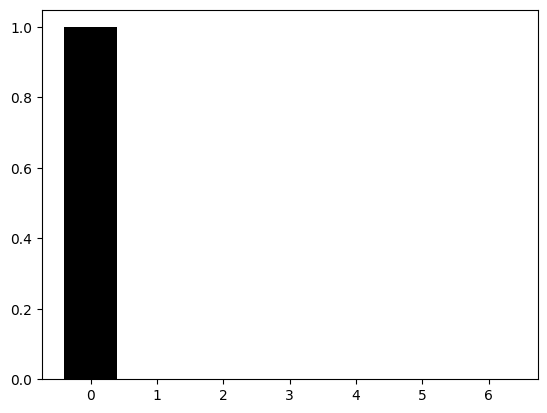

In [93]:
pca = dd.PCA( n_components=X.shape[1] )

principal_components = pca.fit_transform( X )

# plot explained variable
features = range( pca.n_components_ )

plt.bar( features, pca.explained_variance_ratio_, color='black' )

# pca component
df_pca = pd.DataFrame( principal_components )

### 4.3.2 UMAP

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

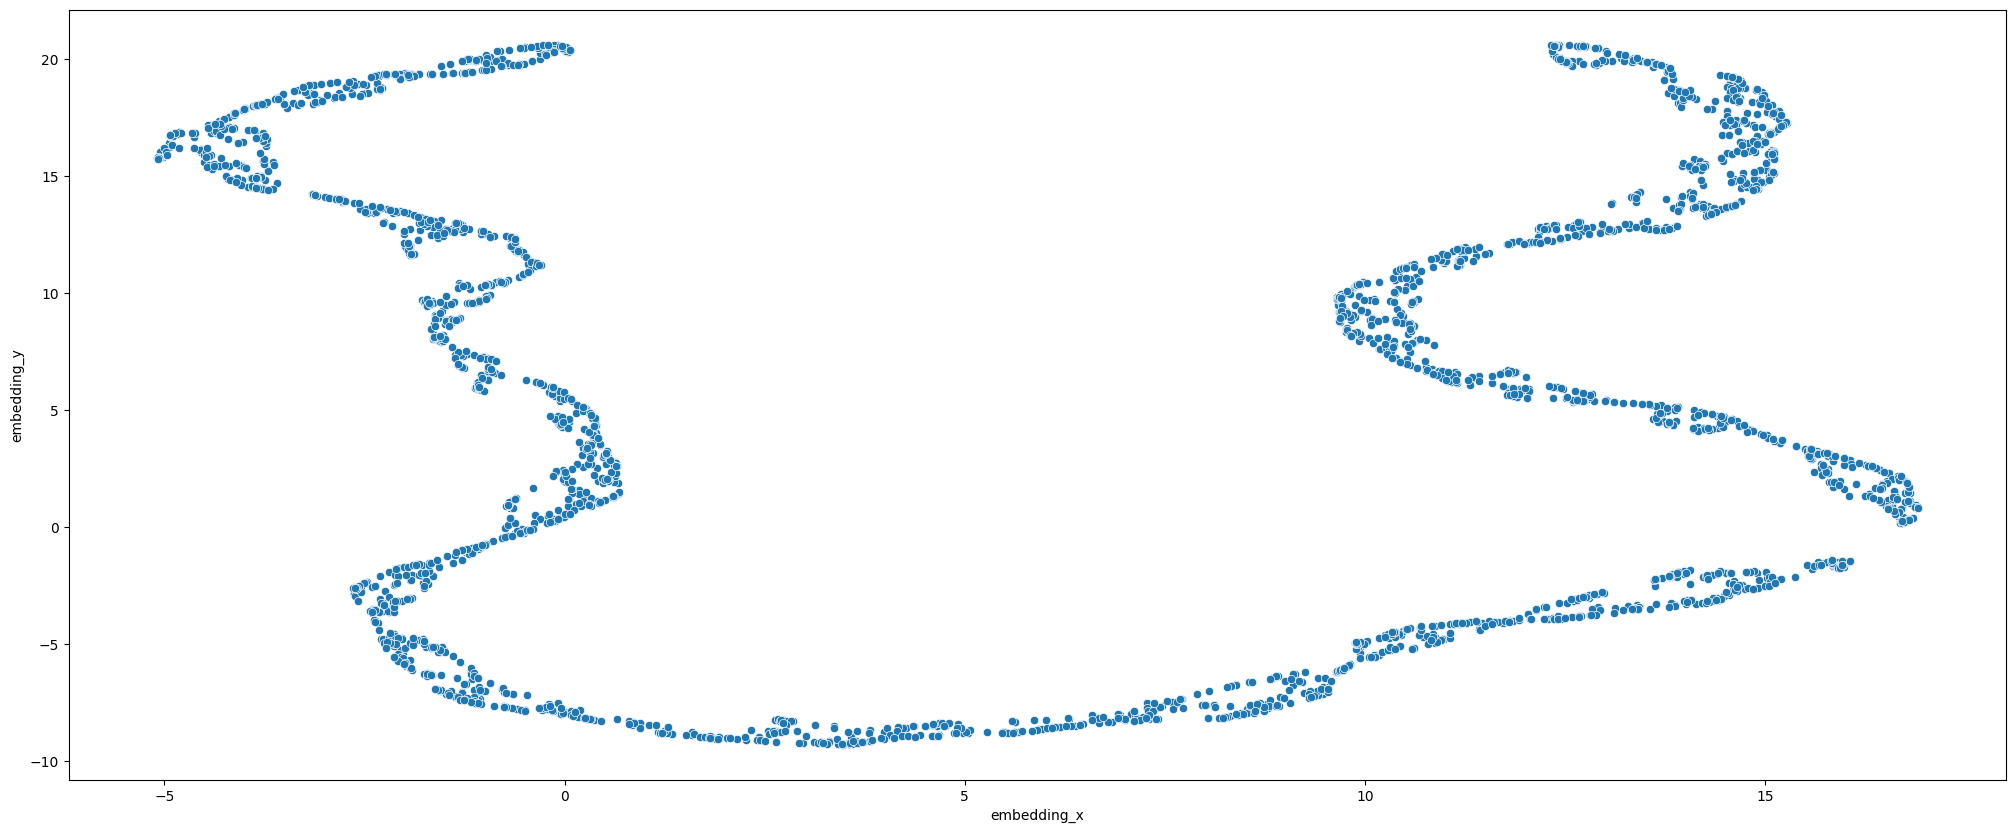

In [94]:
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(25, 10))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.3 T-SNE

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

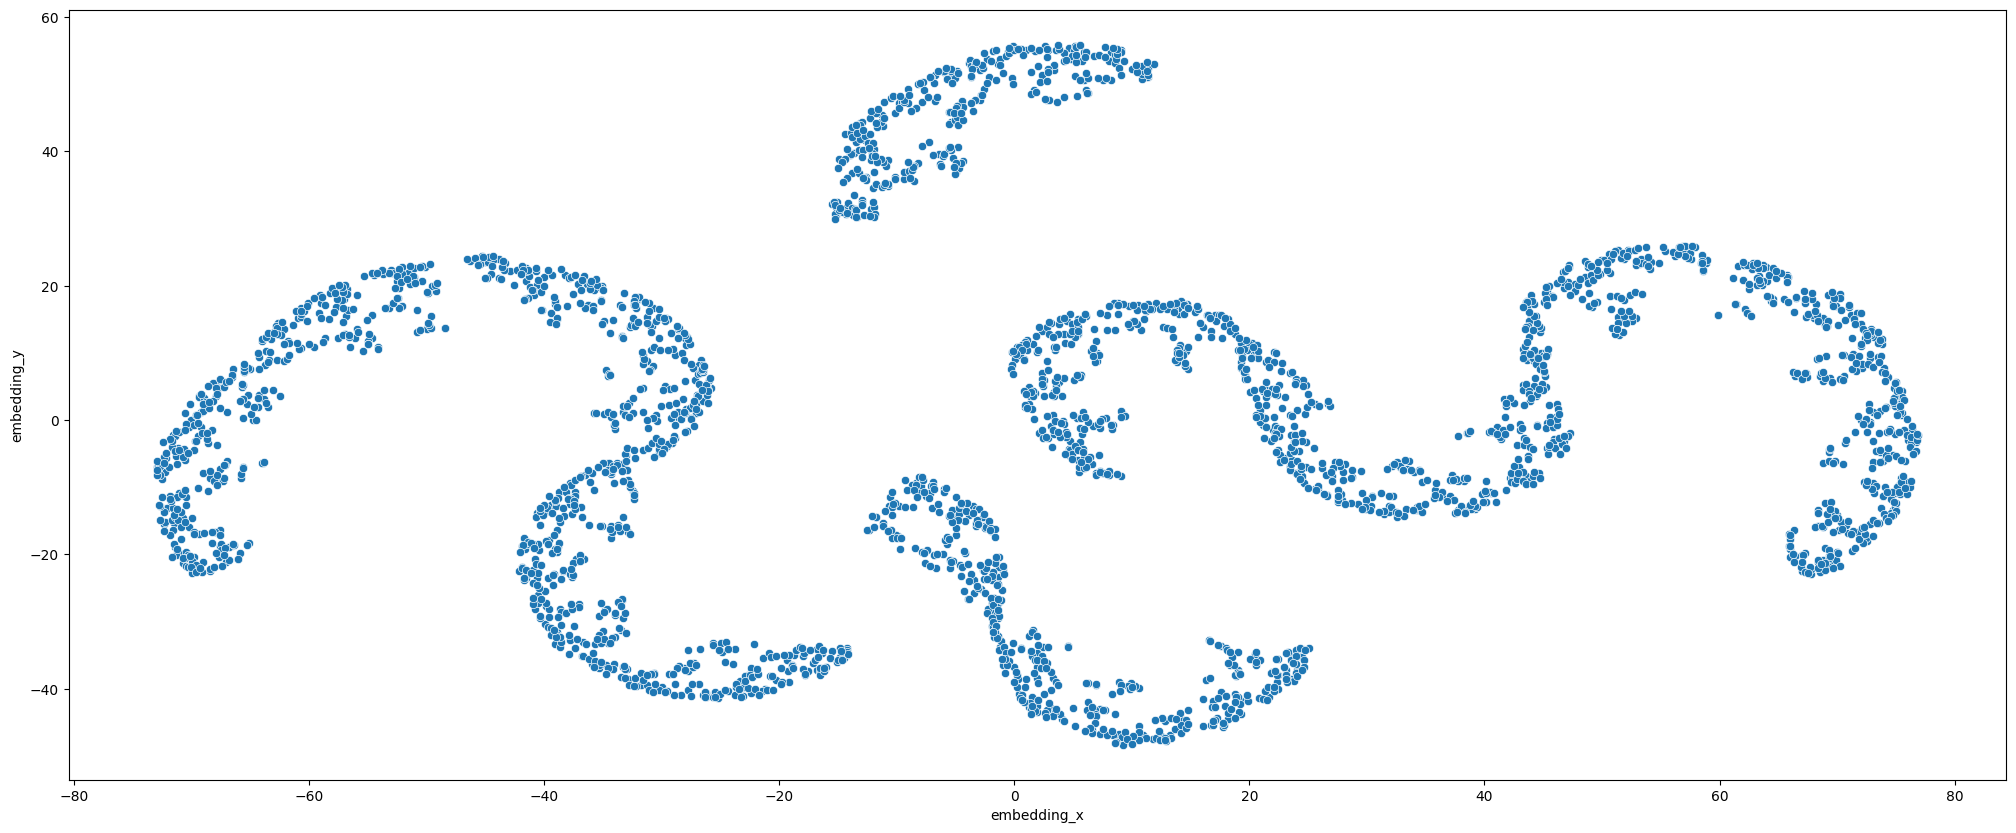

In [95]:
reducer = mn.TSNE(n_components=2, n_jobs=-1, random_state=42)
#df_tsne = mm.fit_transform(X)
embedding = reducer.fit_transform(X)

# embedding
df_pca['embedding_x'] = embedding[:, 0]
df_pca['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(25, 10))
sns.scatterplot(x='embedding_x', y='embedding_y', data=df_pca)

### 4.3.4 Tree-Based Embedding

In [96]:
# training dataset
X = df4.drop(columns=['customer_id', 'gross_revenue'], axis=1)
y = df4['gross_revenue']

# model definition
rf_model = en.RandomForestRegressor(n_estimators=100, random_state=42)

# model training
rf_model.fit(X, y)

df_leaf = pd.DataFrame( rf_model.apply( X ) )

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

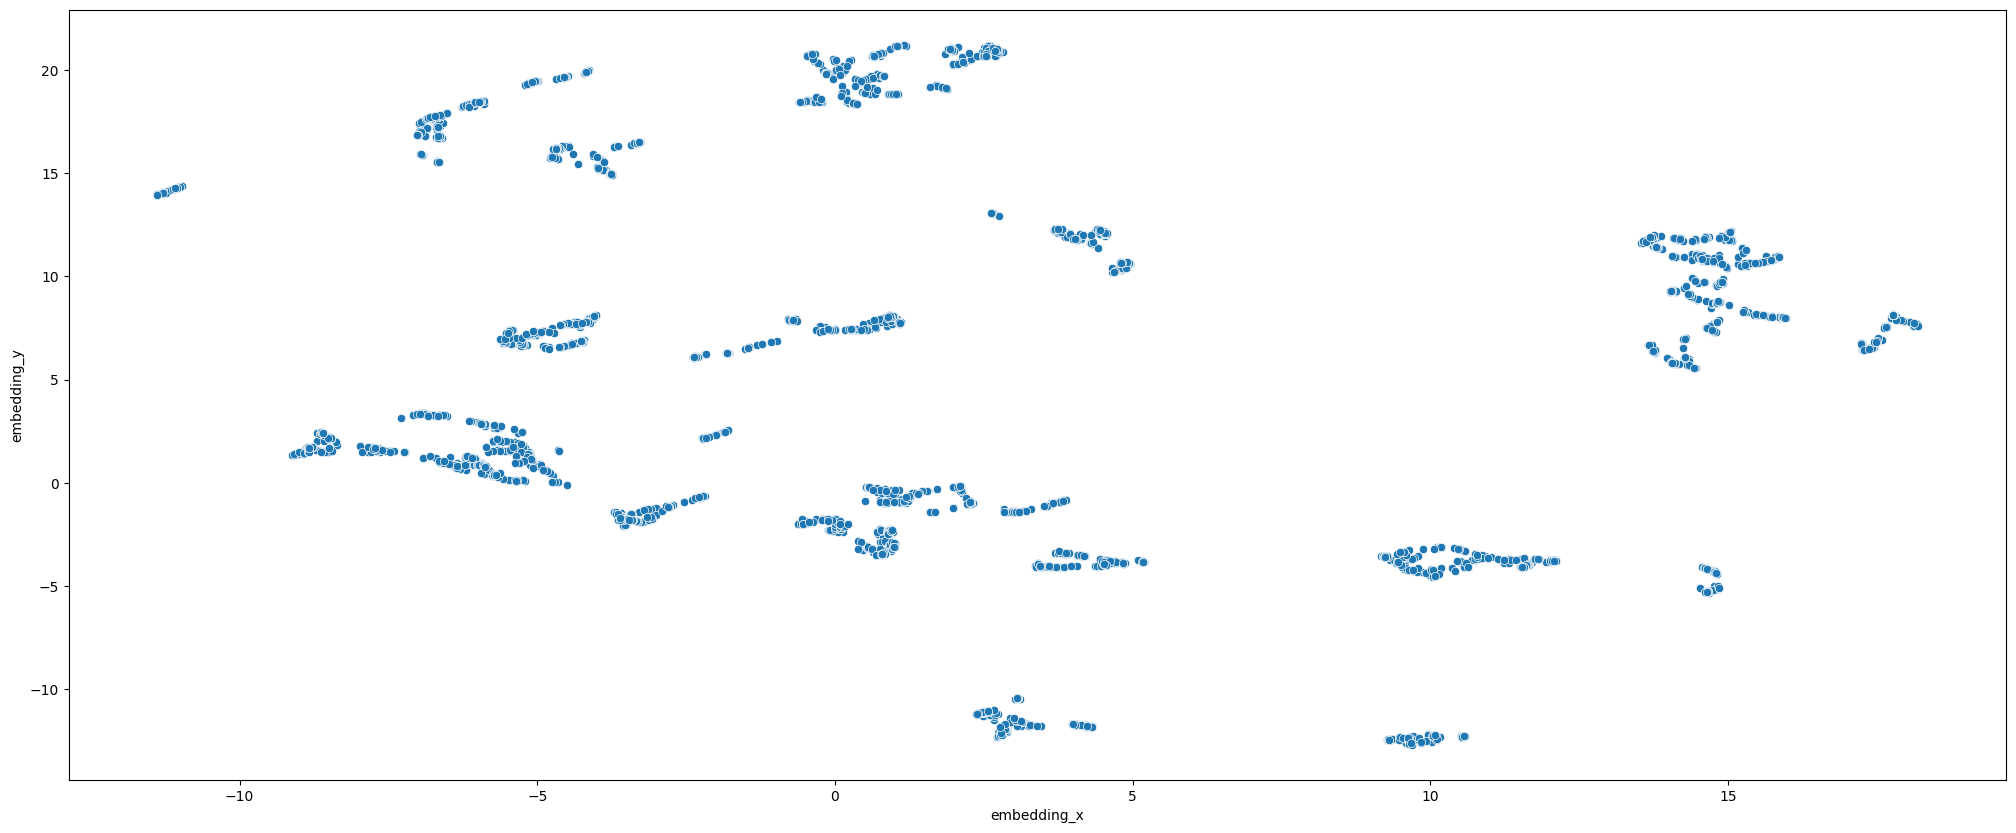

In [112]:
# reduce dimensionality
reducer = umap.UMAP( random_state=42 )
embedding = reducer.fit_transform( df_leaf )

# embedding
df_tree = pd.DataFrame()
df_tree['embedding_x'] = embedding[:, 0]
df_tree['embedding_y'] = embedding[:, 1]

# plot UMAP
plt.figure(figsize=(25, 10))
sns.scatterplot( x='embedding_x', 
                 y='embedding_y', 
                 data=df_tree )

# 5. Hyperparameter Fine Tunning

In [99]:
X_kmeans = df_tree.copy()
X_gmm = df_tree.copy()
X_gmm = mm.fit_transform(X_gmm)

In [100]:
clusters = np.arange(2,51,1)

## 5.1 K-Means

In [101]:
from sklearn import metrics as m

In [102]:
kmeans_list = []

for k in clusters:
    # model definition
    kmeans_model = c.KMeans(n_clusters=k)

    # model training
    kmeans_model.fit(X_kmeans)

    # model predict
    labels = kmeans_model.predict(X_kmeans)

    # model performance
    sil = m.silhouette_score(X_kmeans, labels, metric='euclidean')
    kmeans_list.append(sil)

Text(0.5, 1.0, 'Silhouette Score VS K')

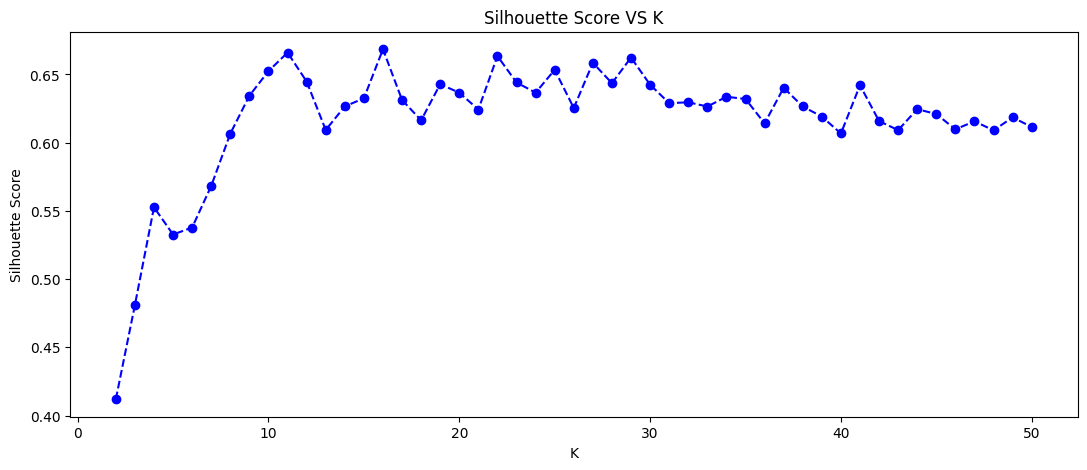

In [103]:
plt.figure(figsize=(13,5))
plt.plot(clusters, kmeans_list, linestyle='--', marker='o', color='b')
plt.xlabel('K')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score VS K')

## 5.2 GMM 

In [104]:
gmm_list = []

for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components= k)

    # model training
    gmm_model.fit(X_gmm)

    # model predict
    labels = gmm_model.predict(X_gmm)

    # model performance
    sil = m.silhouette_score(X_gmm, labels, metric='euclidean')
    gmm_list.append(sil)

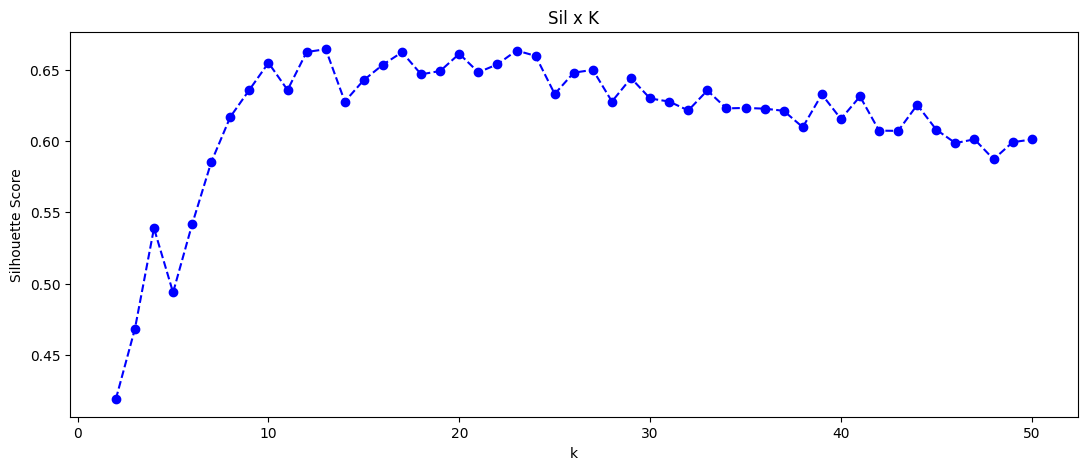

In [114]:
plt.figure(figsize=(13,5))
plt.plot( clusters, gmm_list, linestyle='--', marker='o', color='b' )
plt.xlabel( 'k');
plt.ylabel( 'Silhouette Score');
plt.title( 'Sil x K');

## 5.3 Results

In [115]:
df_results = pd.DataFrame({'K-Means': kmeans_list,
                           'GMM': gmm_list}).T
df_results.columns = clusters

In [116]:
df_results.style.highlight_max(color='lightgreen', axis=1)

,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50
K-Means,0.411965,0.480980,0.552632,0.532691,0.537793,0.568311,0.606603,0.634423,0.652452,0.666025,0.644809,0.609310,0.626578,0.632502,0.668490,0.631290,0.616388,0.642862,0.636612,0.624295,0.663469,0.644107,0.636645,0.653378,0.625397,0.658534,0.643602,0.662372,0.642489,0.628924,0.629625,0.626494,0.633635,0.632033,0.614157,0.640225,0.626529,0.619102,0.606726,0.642092,0.615810,0.609191,0.624587,0.620952,0.609791,0.615650,0.609032,0.618522,0.611482
GMM,0.419020,0.468325,0.538864,0.493832,0.541651,0.585156,0.616890,0.635886,0.654810,0.635776,0.662394,0.664343,0.627682,0.642778,0.653539,0.662224,0.646757,0.649075,0.661147,0.648165,0.653772,0.663436,0.659666,0.632981,0.647916,0.649873,0.627680,0.644109,0.629813,0.627668,0.621433,0.635416,0.622878,0.623185,0.622682,0.621179,0.609676,0.632670,0.615470,0.631233,0.607271,0.607111,0.625344,0.607921,0.598565,0.601198,0.587221,0.599167,0.601081


# 6. Model Training

In [117]:
df6 = X_kmeans.copy()

## 6.1 Final Model

In [119]:
# model definition
gmm_model_final = mx.GaussianMixture(n_components=8, n_init=300, random_state=42)

# model training
gmm_model_final.fit(df6)

# m==clustering
labels = gmm_model_final.predict(df6)

In [120]:
print(' Silouette Score: {}'.format(m.silhouette_score(df6, labels, metric='euclidean' )))

 Silouette Score: 0.5984246730804443


# 7. Cluster Analysis

In [121]:
df7 = df6.copy()
df7['cluster'] = labels

## 7.1 Visual Inspection

<Axes: xlabel='embedding_x', ylabel='embedding_y'>

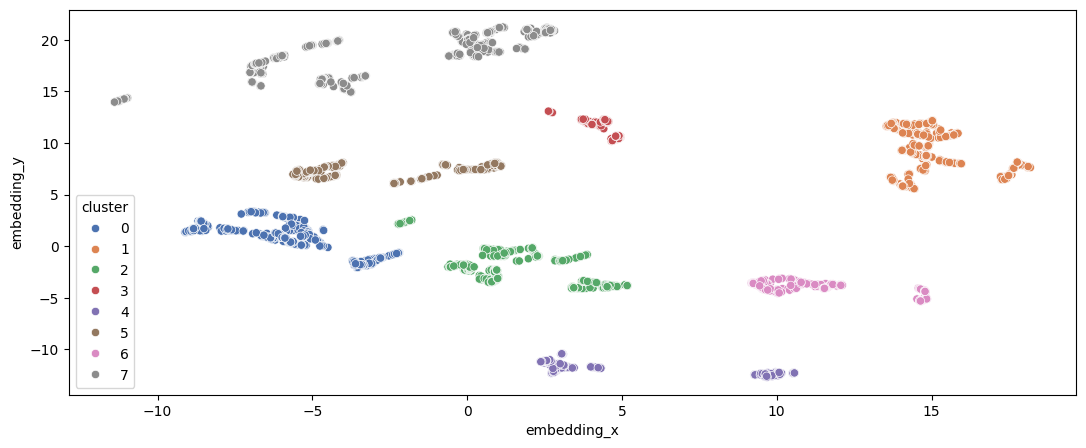

In [122]:
plt.figure(figsize=(13,5))
sns.scatterplot(data=df7, x='embedding_x', y='embedding_y', hue='cluster', palette='deep' )

## 7.4 Cluster Profile

In [143]:
df74 = df41.copy()
df74['cluster'] = labels

df74.head()

,customer_id,gross_revenue,recency_days,quantity_products,frequency_days,returns,avg_recency_days,cluster
0,17850,5391.21,372.0,297.0,148.500000,40.0,35.500000,1
1,13047,3232.59,56.0,171.0,0.537736,35.0,27.250000,4
2,12583,6705.38,2.0,232.0,0.623656,50.0,23.187500,1
3,13748,948.25,95.0,28.0,0.100358,0.0,92.666667,7
4,15100,876.00,333.0,3.0,0.073171,22.0,8.600000,7


In [146]:
# Number of customer
df_cluster = df74[['customer_id', 'cluster']].groupby('cluster').count().reset_index()
df_cluster['perc_customer'] = 100* ( df_cluster['customer_id'] / df_cluster['customer_id'].sum() )

# Avg Gross revenue
avg_gross_revenue = df74[['gross_revenue', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, avg_gross_revenue, on='cluster', how='inner')

# Avg recency days
avg_recency = df74[['recency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, avg_recency, on='cluster', how='inner')

# Avg quantity_products
avg_quantity_products = df74[['quantity_products', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, avg_quantity_products, on='cluster', how='inner')

# avg_Frequency
avg_frequency = df74[['frequency_days', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, avg_frequency, how='inner', on='cluster')

# Returns
avg_returns = df74[['returns', 'cluster']].groupby('cluster').mean().reset_index()
df_cluster = pd.merge(df_cluster, avg_returns, on='cluster', how='inner')

df_cluster.sort_values('gross_revenue', ascending=False)


,cluster,customer_id,perc_customer,gross_revenue,recency_days,quantity_products,frequency_days,returns
1,1,468,15.768194,8836.136389,21.438034,424.134615,3.062568,149.271368
4,4,231,7.783019,3480.392165,35.125541,144.658009,3.284039,23.251082
2,2,438,14.757412,2634.785068,52.022831,98.168950,2.096612,19.404110
6,6,265,8.928571,1895.166868,45.781132,139.732075,0.637868,15.535849
0,0,478,16.105121,1286.280439,61.558577,57.169456,1.475028,12.761506
5,5,321,10.815364,969.604393,75.529595,37.442368,1.821444,5.389408
3,3,132,4.447439,643.330530,107.060606,26.575758,4.207665,29.371212
7,7,635,21.394879,610.584992,110.240945,15.075591,3.287172,6.292913
